In [7]:

# Global stiffness matrix for triangular elements
def global_stiffness_matrix_triangular(nodes, elements, k1, k2, distance_x):
    num_nodes = len(nodes)
    K_global = np.zeros((num_nodes, num_nodes))

    for element in elements:
        e1, e2, e3 = element
        x1, y1 = nodes[e1 - 1]
        x2, y2 = nodes[e2 - 1]
        x3, y3 = nodes[e3 - 1]

        # Compute the average x-coordinate of the element
        x_avg = (x1 + x2 + x3) / 3
        middle = distance_x / 2
        # print(x1,x2,x3,x_avg)

        if x_avg < middle: 
            k = k1
        else: 
            k = k2

        # Area of the element
        A = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))

        # Compute the coefficients b and c
        b1, b2, b3 = y2 - y3, y3 - y1, y1 - y2
        c1, c2, c3 = x3 - x2, x1 - x3, x2 - x1

        # Local stiffness matrix
        K_local = (1 / (8 * k * A)) * np.array([
            [b1**2 + c1**2, b1*b2 + c1*c2, b1*b3 + c1*c3],
            [b2*b1 + c2*c1, b2**2 + c2**2, b2*b3 + c2*c3],
            [b3*b1 + c3*c1, b3*b2 + c3*c2, b3**2 + c3**2]
        ])

        for i, ni in enumerate(element):
            for j, nj in enumerate(element):
                K_global[ni - 1, nj - 1] += K_local[i, j]

    return K_global


In [8]:

# Generate elements for triangular mesh
def generate_elements(n):
    elements = []
    for i in range(n - 1):
        for j in range(n - 1):
            top_left = i * n + j + 1
            top_right = top_left + 1
            bottom_left = top_left + n
            bottom_right = bottom_left + 1

            if (i + j) % 2 == 0:
                elements.append((top_left, top_right, bottom_left))
                elements.append((bottom_left, top_right, bottom_right))
            else:
                elements.append((top_left, bottom_right, bottom_left))
                elements.append((top_left, top_right, bottom_right))
    return elements

# Generate nodes for the grid
def generate_nodes(n, distance_x, distance_y):
    x_coords = np.linspace(0, distance_x, n)
    y_coords = np.linspace(0, distance_y, n)
    nodes = [(x, y) for y in y_coords for x in x_coords]
    return nodes

In [9]:

def apply_boundary_conditions(K_global, F_global, T_left, T_right, T_top, T_bottom, num_nodes):
    s = K_global.shape[0]

    if T_left is not None:
        for i in range(s):
            if i % num_nodes == 0:
                K_global[i, :] = 0
                K_global[i, i] = 1
                F_global[i] = T_left

    if T_right is not None:
        for i in range(s):
            if (i + num_nodes + 1) % num_nodes == 0:
                K_global[i, :] = 0
                K_global[i, i] = 1
                F_global[i] = T_right

    if T_bottom is not None:
        for i in range(num_nodes):
            K_global[i, :] = 0
            K_global[i, i] = 1
            F_global[i] = T_bottom

    if T_top is not None:
        for i in range(num_nodes * (num_nodes - 1), s):
            K_global[i, :] = 0
            K_global[i, i] = 1
            F_global[i] = T_top

    return K_global, F_global


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Visualization of the triangular mesh
def plot_triangular_mesh(num_nodes, elements, U, distance_x, distance_y):
    x = np.tile(np.linspace(0, distance_x, num_nodes), num_nodes)  
    y = np.repeat(np.linspace(0, distance_y, num_nodes), num_nodes) 

    triangles = [[i - 1 for i in el] for el in elements]
    node_values = U.flatten()


    assert len(node_values) == len(x), "Node values (U) must match the number of nodes."
    assert len(x) == len(y), "x and y coordinate arrays must have the same length."
    # print(len(U), len(node_values))

    triang = tri.Triangulation(x, y, triangles)

    plt.figure(figsize=(6, 6))
    plt.tripcolor(triang, node_values, cmap="viridis", shading="gouraud", edgecolors="gray")
    plt.colorbar(label="Node Values")
    plt.title("Triangular Mesh with Node Values and Triangles")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal')
    # plt.grid(True, linestyle="--", color="gray", linewidth=0.5)

    for triangle in triangles:
        coords = [[x[i], y[i]] for i in triangle] + [[x[triangle[0]], y[triangle[0]]]]
        plt.plot(*zip(*coords), color="black", linewidth=0.25)

    # for i, (xi, yi, val) in enumerate(zip(x, y, node_values)):
    #     plt.text(xi, yi, f"{i+1}\n{val:.1f}", color="black", fontsize=5, ha="center", va="center")

    plt.show()


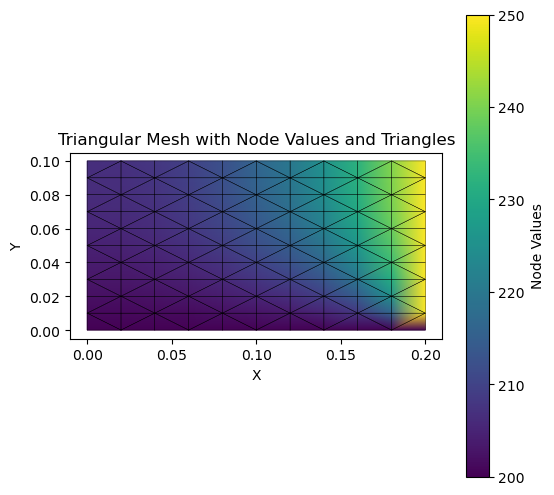

In [20]:
num_nodes = 11
distance_x = 0.2
distance_y = 0.1
k1 = 30
k2 = 20
T_left = None #[K]
T_right = 250 #[K]
T_top = None #[K]
T_bottom = 200 #[K]
elements = generate_elements(num_nodes)
nodes = generate_nodes(num_nodes, distance_x, distance_y)
K_global = global_stiffness_matrix_triangular(nodes, elements, k1, k2, distance_x)
F_global = np.zeros(K_global.shape[0])
U = apply_boundary_conditions(K_global, F_global, T_left, T_right, T_top, T_bottom, num_nodes)
U = np.dot(np.linalg.pinv(K_global), F_global)
U = U.reshape((num_nodes, num_nodes))

plot_triangular_mesh(num_nodes, elements, U, distance_x, distance_y )

In [12]:
def main():
    print("Please provide the following parameters:")
    
    distance_x = float(input("Enter the length of the grid in the x-direction (distance_x): "))
    distance_y = float(input("Enter the length of the grid in the y-direction (distance_y): "))
    num_nodes = int(input("Enter the number of nodes for one side: "))
    k1 = float(input("Enter the thermal conductivity constant of the first material (k1): "))
    k2 = float(input("Enter the thermal conductivity constant of the second material (k2): "))
    
    # Generate nodes and elements
    nodes = generate_nodes(num_nodes, distance_x, distance_y)
    elements = generate_elements(num_nodes)

    # Compute global stiffness matrix
    K_global = global_stiffness_matrix_triangular(nodes, elements, k1, k2, distance_x)
    
    # Generate force vector
    F_global = np.zeros(K_global.shape[0])

    # Apply boundary conditions
    K_global, F_global = apply_boundary_conditions(K_global, F_global, 280, 300, None, None, num_nodes)

    # Solve for displacements
    U = np.dot(np.linalg.pinv(K_global), F_global)
    U = U.reshape((num_nodes, num_nodes))

    plot_triangular_mesh(num_nodes, elements, U, distance_x, distance_y)

# if __name__ == "__main__":
#     main()